# Import libraries

In [1]:
# basemodels
from models import QuantileLinearRegressor, QuantileForestRegressor, QuantileNeuralRegressor
from arima import ARIMA
import quantnn

# metrics for comparison
from metrics import Metrics

# conformal methods to use
from conformal_methods import ACI, CQR, EnbPI, EnCQR

# data generation and subplots
from utils import SyntheticData, create_subplots, \
train_val_test, split_x_y, compute_aci, optimize_conformal, plot_test_PIs

# data science
import pandas as pd
import numpy as np
from sktime.utils.plotting import plot_series
from sktime.utils import plotting
from tqdm import tqdm
import matplotlib.pyplot as plt

import run_experiment

np.random.seed(100)
import torch
torch.manual_seed(100)
import random
random.seed(100)

/home/dirk/bsc-thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = "google"

In [3]:
df, df_train, df_val, df_test, T, tvt_split = run_experiment.get_data(dataset)

In [4]:
quantiles: dict = {"lower": 0.05, "middle": 0.5, "upper" : 0.95}

In [5]:
df

,t,y,y_lag,y_diff,y_diff_lag
0,0,225.85,222.84,3.01,5.01
1,1,233.06,225.85,7.21,3.01
2,2,233.68,233.06,0.62,7.21
3,3,235.11,233.68,1.43,0.62
4,4,236.05,235.11,0.94,1.43
...,...,...,...,...,...
3012,3012,1068.86,1070.85,-1.99,-2.71
3013,3013,1065.85,1068.86,-3.01,-1.99
3014,3014,1060.20,1065.85,-5.65,-3.01
3015,3015,1055.95,1060.20,-4.25,-5.65


## ARIMA

In [6]:
predictions, df_arima = run_experiment.experiment_arima(df, T)

Start forecasting


  2%|▏         | 15/604 [00:32<21:29,  2.19s/it]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

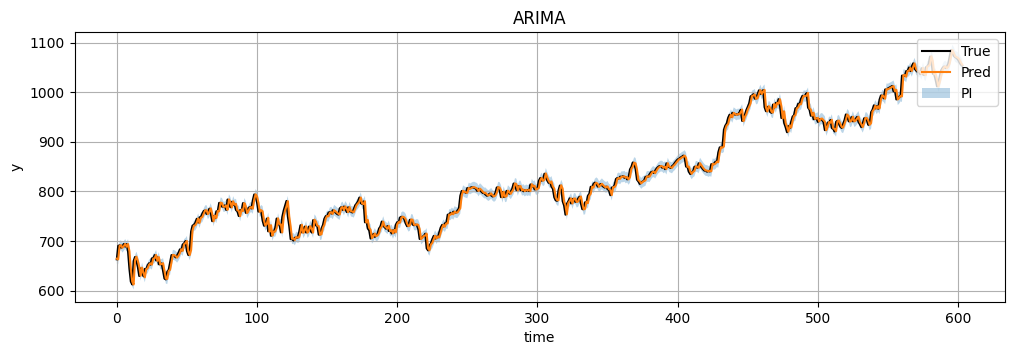

In [ ]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= predictions["pred"].to_numpy(),
               PI_low = predictions["lower_bound"].to_numpy(), PI_hi =  predictions["upper_bound"].to_numpy(), conf_PI_low=None, conf_PI_hi=None,
               x_label="time", y_label="y", title='ARIMA')

In [ ]:
df_arima

,model_name,RMSE,PICP,PIAW,PINAW,CWC
0,ARIMA,9.864323,0.786424,21.60564,0.045715,0.648056


## Linear regression

Define metrics

In [6]:
df_linear = pd.DataFrame({"model_name" : [],
                          "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [7]:
predictions = []  # to store different predictions

Quantile estimation

(3017, 3)


Text(0.5, 0, 'time')

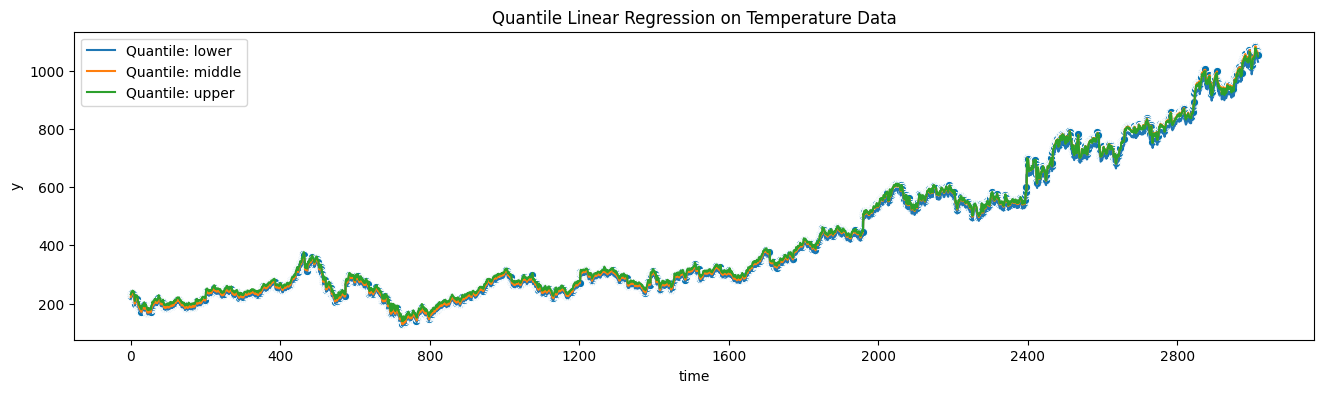

In [8]:
QLR_predictions = {}
        
# fit each prompted quantile and predict on all samples

QLR = QuantileLinearRegressor(quantiles=quantiles.values())
QLR.fit(df_train["y_lag"].to_numpy().reshape(-1,1), 
        df_train["y"].to_numpy())

y_pred = QLR.predict(df["y_lag"].to_numpy().reshape(-1,1))
print(y_pred.shape)

QLR_predictions["lower"] = y_pred[:, 0].reshape(1,-1,1)
QLR_predictions["middle"] = y_pred[:, 1].reshape(1,-1,1)
QLR_predictions["upper"] = y_pred[:, 2].reshape(1,-1,1)


QLR.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], QLR_predictions)
plt.title("Quantile Linear Regression on Temperature Data")
plt.xlabel("time")

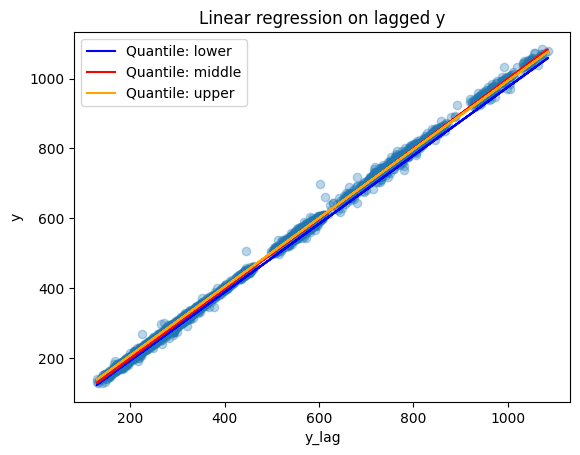

In [9]:
# this cell is to show the correlation between y_lag and y
plt.scatter(df["y_lag"], df["y"], alpha=0.3)
plt.plot(df["y_lag"], QLR_predictions["lower"].flatten(), color="blue",  label="Quantile: lower")

plt.plot(df["y_lag"], QLR_predictions["middle"].flatten(), color="red", label="Quantile: middle")
plt.plot(df["y_lag"], QLR_predictions["upper"].flatten(), color="orange", label="Quantile: upper")


plt.title("Linear regression on lagged y")
plt.xlabel("y_lag")
plt.ylabel("y")
plt.legend()
plt.show()

CQR

  0%|          | 0/604 [00:00<?, ?it/s]

[22:31:27] WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun  ]8;id=739784;file:///home/dirk/bsc-thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=412125;file:///home/dirk/bsc-thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py#448\448]8;;\
                    for more info.)                                                                                

100%|██████████| 604/604 [01:22<00:00,  7.30it/s]


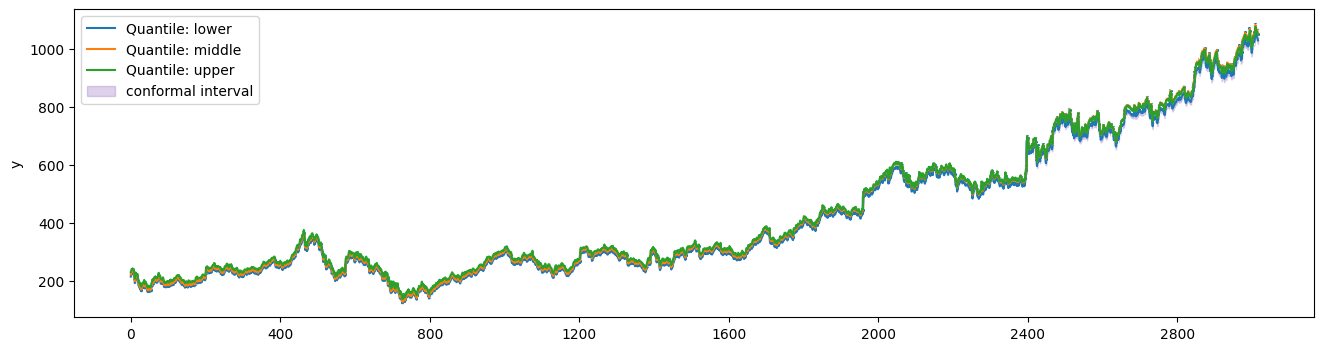

In [10]:
qcr = CQR()
conformal_intervals = qcr.create_conformal_interval(QLR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split)
qcr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QLR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QLR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QLR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_linear.loc[0] = metric.computeAll(model_name="Linear CQR").values()

<Figure size 640x480 with 0 Axes>

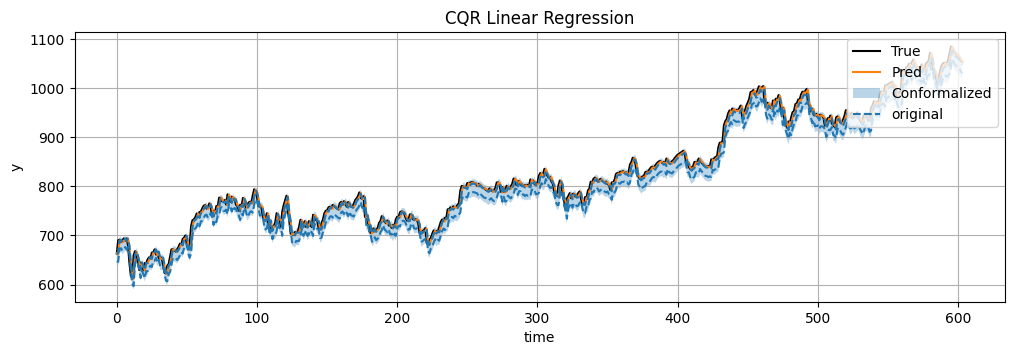

In [11]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QLR_predictions["middle"][0][df_test["t"],0],
               PI_low = QLR_predictions["lower"][0][df_test["t"],0], PI_hi = QLR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='CQR Linear Regression')

ACI

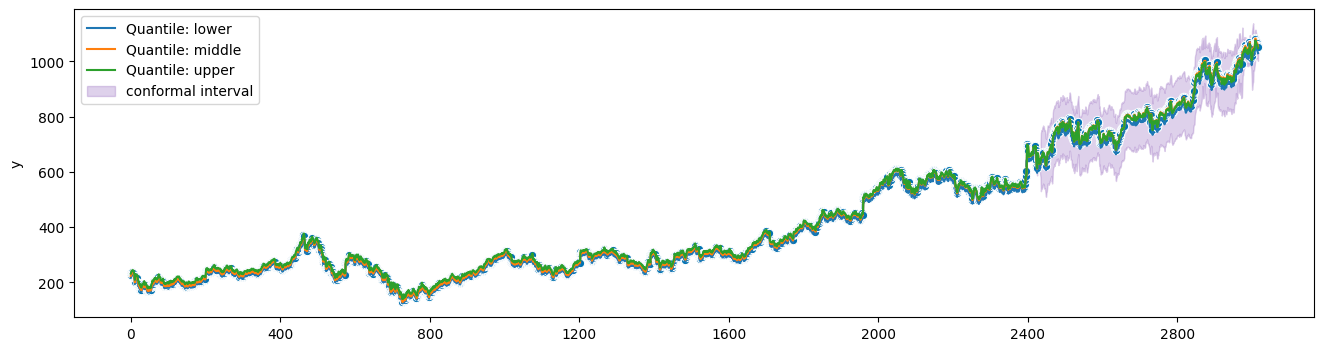

In [12]:
aci = ACI()
conformal_intervals = aci.create_conformal_interval(QLR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split)
aci.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QLR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QLR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QLR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_linear.loc[1] = metric.computeAll(model_name="Linear ACI").values()

CQR and ACI plots

<Figure size 640x480 with 0 Axes>

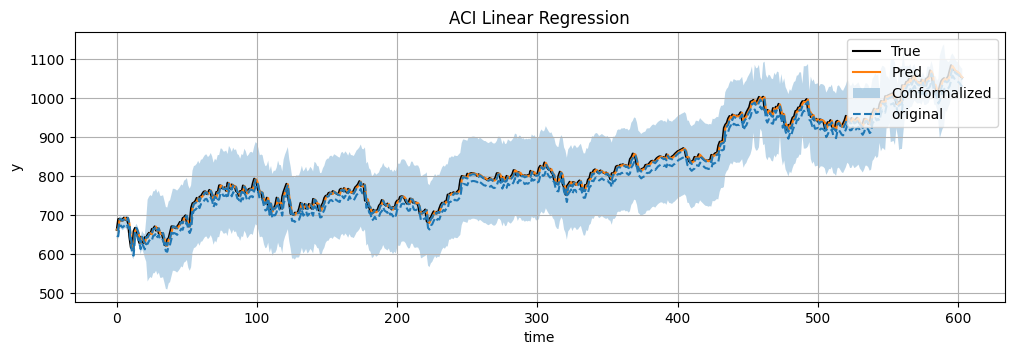

In [13]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QLR_predictions["middle"][0][df_test["t"],0],
               PI_low = QLR_predictions["lower"][0][df_test["t"],0], PI_hi = QLR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='ACI Linear Regression')

EnbPI

In [14]:
X_bootstrap = np.concatenate([df_train["y_lag"].to_numpy().reshape(-1,1), 
                              df_val["y_lag"].to_numpy().reshape(-1,1)], axis=0)
X_bootstrap.shape

(2413, 1)

In [15]:
y_bootstrap = np.concatenate([df_train["y"].to_numpy(), df_val["y"].to_numpy()])
y_bootstrap.shape

(2413,)

In [16]:
n_bs_samples = 20
enbpi = EnbPI(n_bs_samples=n_bs_samples)
bs_indices, bs_train_data = enbpi.bootstrap(X_bootstrap, y_bootstrap)

batch: 0 batch: 1 batch: 2 batch: 3 batch: 4 batch: 5 batch: 6 batch: 7 batch: 8 batch: 9 batch: 10 batch: 11 batch: 12 batch: 13 batch: 14 batch: 15 batch: 16 batch: 17 batch: 18 batch: 19 

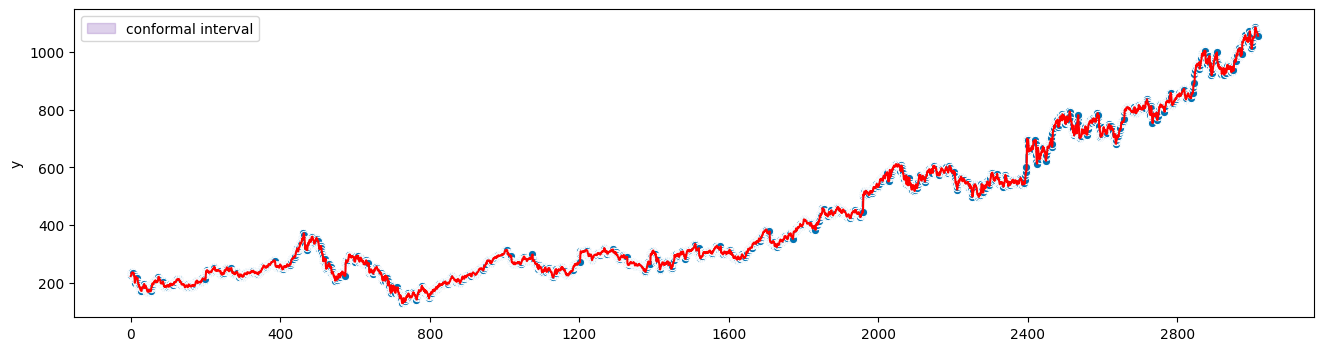

In [17]:
model = QuantileLinearRegressor(quantiles=[0.5])

bs_train_preds, bs_test_preds = enbpi.train(model, n_bs_samples=n_bs_samples,
                                        bs_train_data=bs_train_data,
                                        X_train=X_bootstrap,
                                        X_test=df_test["y_lag"].to_numpy().reshape(-1,1))

conformal_intervals = enbpi.create_conformal_interval_online(bs_indices=bs_indices,
                            bs_train_preds=bs_train_preds,
                            bs_test_preds=bs_test_preds,
                            y_train=y_bootstrap,
                            y_test=df_test["y"].to_numpy())

preds = np.mean(np.concatenate([bs_train_preds, bs_test_preds], axis=1), axis=0)


enbpi.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], preds, df_test["t"].to_numpy().reshape(-1,1), 
                            conformal_intervals)

metric = Metrics(df_test["y"].to_numpy(), preds[df_test["t"]], conformal_intervals[:,0], conformal_intervals[:,1],)
df_linear.loc[2] = metric.computeAll(model_name="Linear EnbPI").values()

In [18]:
df_linear

,model_name,RMSE,PICP,PIAW,PINAW,CWC
0,Linear CQR,9.989641,0.751656,36.397991,0.077013,0.476960
1,Linear ACI,9.989641,0.991722,195.521957,0.413698,0.455524
2,Linear EnbPI,9.870972,0.841060,25.750823,0.054485,0.851935


<Figure size 640x480 with 0 Axes>

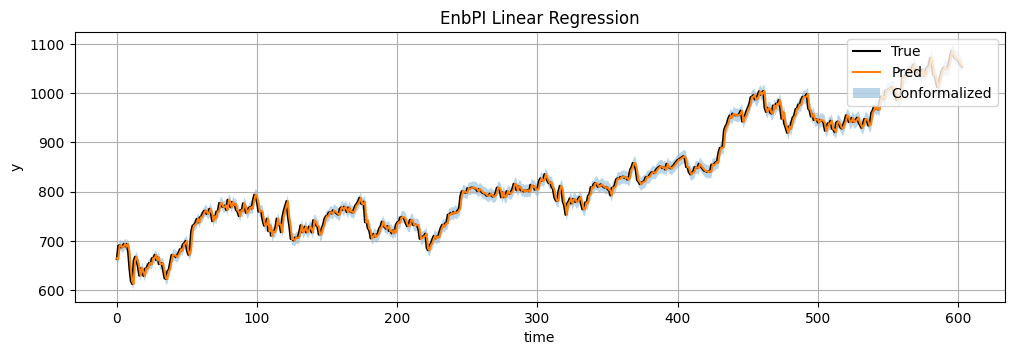

In [19]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= preds[df_test["t"]],
               PI_low = None, PI_hi = None,
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='EnbPI Linear Regression')

In [20]:

def local_coverage(y_test, y_lower, y_upper , interval: tuple[int, int]):
    """Compute coverage for a specified interval."""
    l, r = interval
    not_covered = ~((y_test[l:r] >= y_lower[l:r]) & (y_test[l:r] <= y_upper[l:r]))

    return 1 - np.mean(not_covered)


local_coverage(df_test["y"].to_numpy(), conformal_intervals[:,0], conformal_intervals[:,1], (0,200))

0.74

In [21]:
len(df)

3017

In [22]:
# we have a test set of 600 samples, so we use a local window of 20 samples
covs = []
for i in range(10, 600):
    cov = local_coverage(df_test["y"].to_numpy(), conformal_intervals[:,0], conformal_intervals[:,1], (i-10,i))
    covs.append(cov)

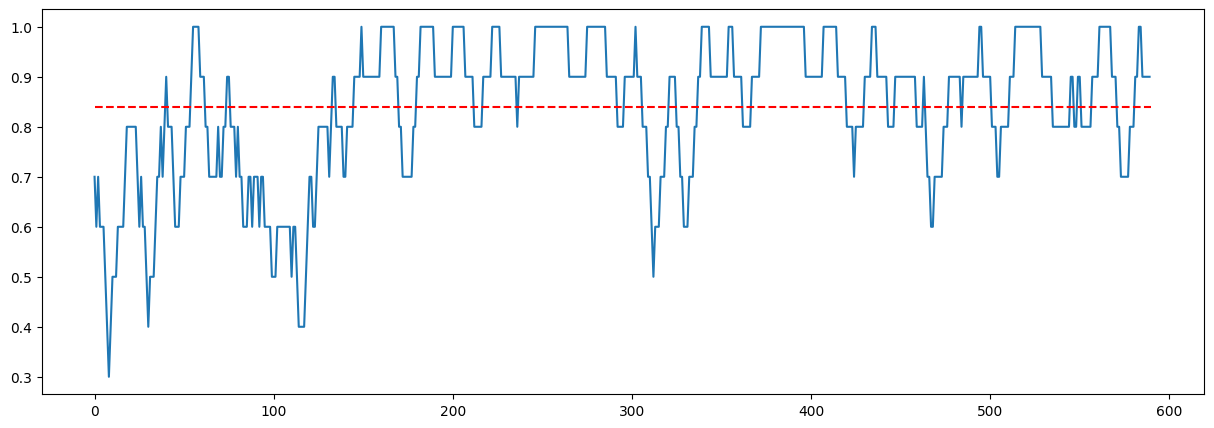

0.8396610169491526


In [23]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(covs)
# create dashed mean plot
ax.plot([0, len(covs)], [np.mean(covs), np.mean(covs)], linestyle="--", color="red")
plt.show()
print(np.mean(covs))

EnCQR

In [24]:
encqr = EnCQR(n_ensembles=3, alpha=0.1)
train_data, train_label, val_x, val_y, test_x, test_y = encqr.dataloader(df_train, df_val, df_test)


In [25]:
model = QuantileLinearRegressor(quantiles=[0.05, 0.5, 0.95])
epsilon_low, epsilon_hi = encqr.train(df_train, train_label, model=model,
                                        train_data=train_data)


Training model for Sb: 0 Training model for Sb: 1 Training model for Sb: 2 

In [26]:
test_label = df_test["y"].to_numpy()

In [27]:
PI, conf_PI = encqr.construct_PI(epsilon_low=epsilon_low, epsilon_hi=epsilon_hi
                   , test_x = test_x,
                   test_y = test_y, test_label=test_label)

Creating test predictions for Sb 0
Creating test predictions for Sb 1
Creating test predictions for Sb 2


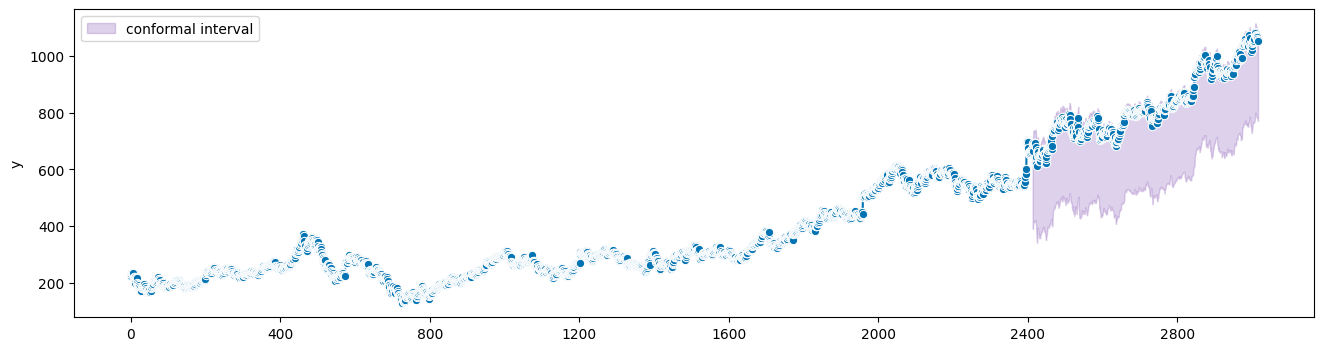

In [28]:

encqr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], PI, df_test["t"].to_numpy().reshape(-1,1), conf_PI[:,0][:,[0,2]].reshape(-1,2))

preds =  conf_PI[:, :, 1]


metric = Metrics(df_test["y"].to_numpy(), preds, conf_PI[:,:, 0].flatten(), conf_PI[:,:,2].flatten(),)
df_linear.loc[3] = metric.computeAll(model_name="Linear EnCQR").values()

<Figure size 640x480 with 0 Axes>

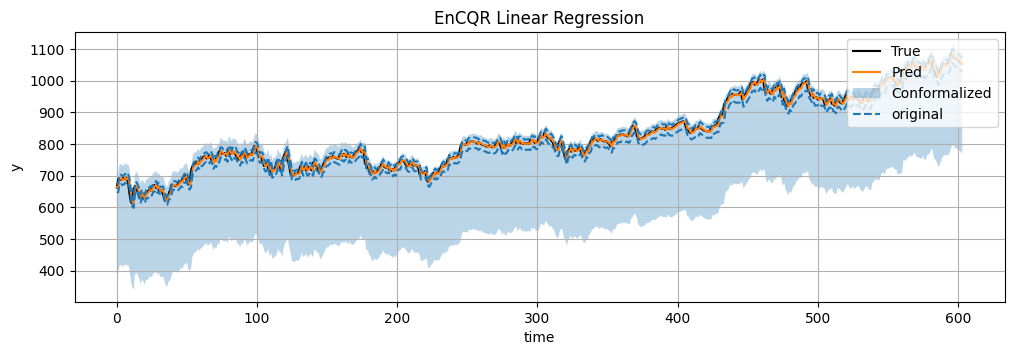

In [29]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= PI[:, :, 1].flatten(),
               PI_low = PI[:, :, 0].flatten(), PI_hi = PI[:, :, 2].flatten(),
               conf_PI_low=conf_PI[:, :, 0].flatten(), conf_PI_hi=conf_PI[:, :, 2].flatten(),
               x_label="time", y_label="y", title='EnCQR Linear Regression')

In [30]:
df_linear

,model_name,RMSE,PICP,PIAW,PINAW,CWC
0,Linear CQR,9.989641,0.751656,36.397991,0.077013,0.476960
1,Linear ACI,9.989641,0.991722,195.521957,0.413698,0.455524
2,Linear EnbPI,9.870972,0.841060,25.750823,0.054485,0.851935
3,Linear EnCQR,9.894384,0.993377,307.685055,0.651020,0.268657


Plot testing

In [31]:
def local_cov(y_test, y_lower, y_upper):
    not_covered = ~((y_test >= y_lower) & (y_test <= y_upper))
    
    return 1 - np.mean(not_covered)


local_cov(df_test["y"].to_numpy(), conf_PI[:,:, 0].flatten(), conf_PI[:,:,2].flatten())

0.9933774834437086

## Quantile Forest

Define metrics

In [32]:
df_forest = pd.DataFrame({"model_name" : [],
                          "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [33]:
predictions = []

Quantile estimation

In [34]:
X_all, y_all = df["y_diff_lag"].to_numpy().reshape(-1,1), df["y_diff"].to_numpy()
X_train, y_train = df_train["y_diff_lag"].to_numpy().reshape(-1,1), df_train["y_diff"].to_numpy()
X_val, y_val = df_val["y_diff_lag"].to_numpy().reshape(-1,1), df_val["y_diff"].to_numpy()
X_test, y_test = df_test["y_diff_lag"].to_numpy().reshape(-1,1), df_test["y_diff"].to_numpy()

In [35]:
QFR = QuantileForestRegressor(y_real=df["y"].to_numpy(), quantiles=[0.05, 0.5, 0.95], max_depth=2, differencing=False)
QFR.fit(X_train, y_train)

In [36]:
y_pred = QFR.predict(X_all)
QFR_predictions = {}

3017it [00:26, 111.95it/s]


In [37]:
y_pred.shape

(3017, 3)

In [38]:
QFR_predictions["lower"] = y_pred[:, 0].reshape(1, -1, 1)
QFR_predictions["middle"] = y_pred[:, 1].reshape(1, -1, 1)
QFR_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)

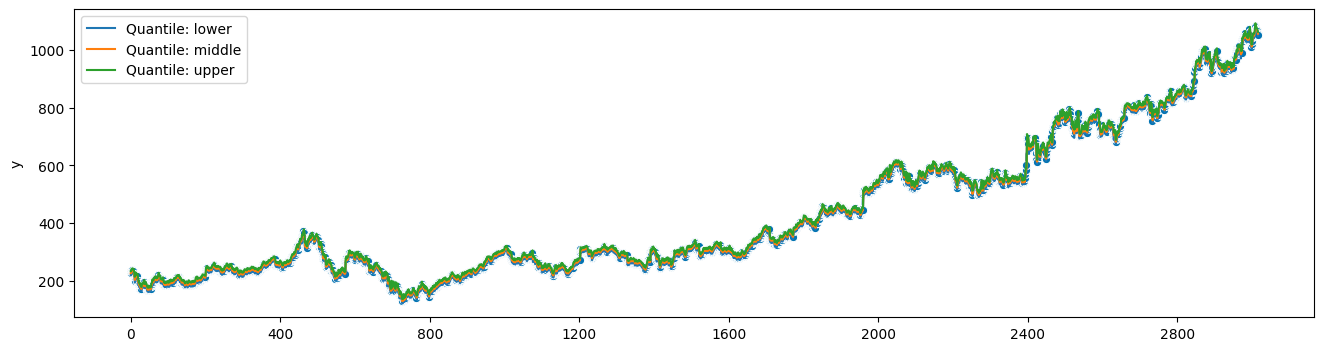

In [39]:
QFR.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], QFR_predictions)

CQR

  0%|          | 0/604 [00:00<?, ?it/s]

100%|██████████| 604/604 [00:01<00:00, 394.62it/s]


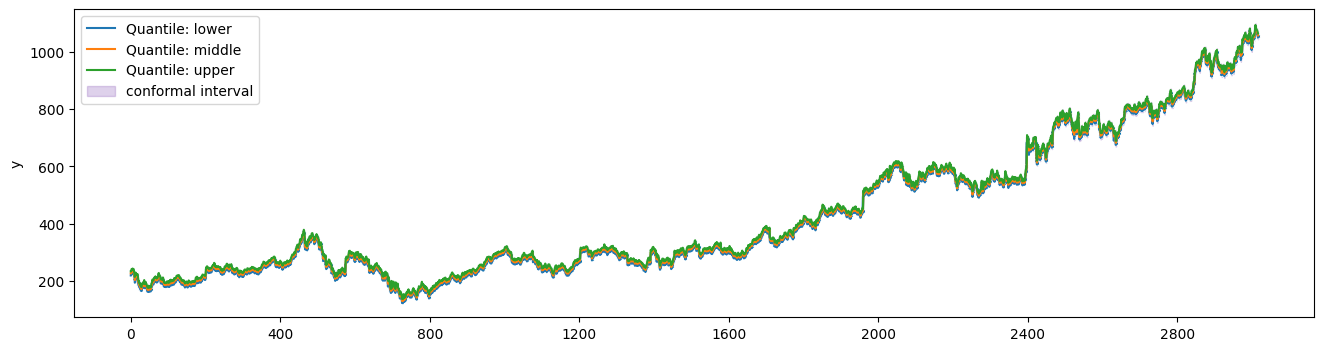

In [40]:
qcr = CQR()
conformal_intervals = qcr.create_conformal_interval(QFR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split)
qcr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QFR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QFR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QFR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_forest.loc[0] = metric.computeAll(model_name="Forest CQR").values()

<Figure size 640x480 with 0 Axes>

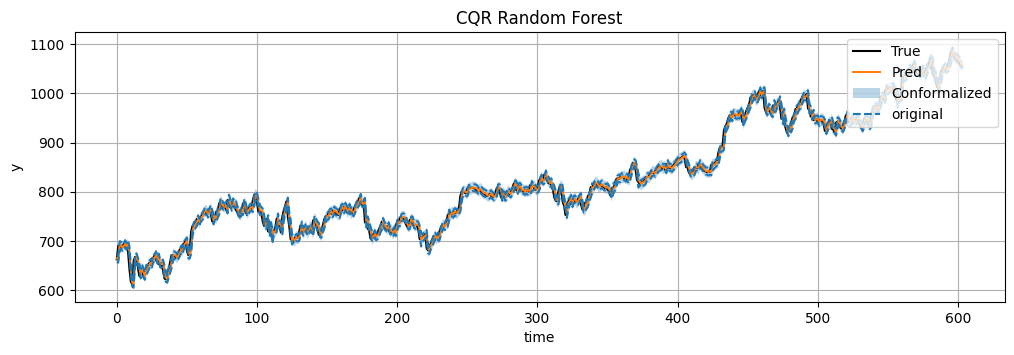

In [41]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QFR_predictions["middle"][0][df_test["t"],0],
               PI_low = QFR_predictions["lower"][0][df_test["t"],0], PI_hi = QFR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='CQR Random Forest')

ACI

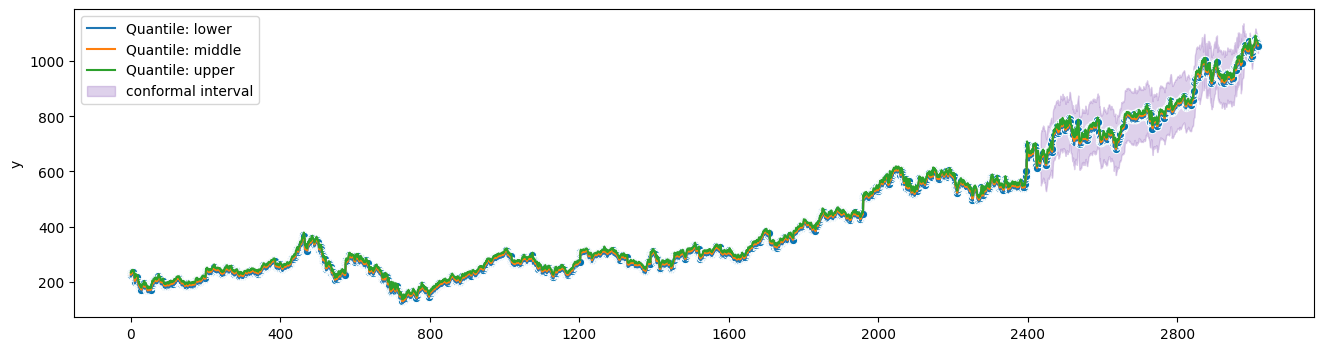

In [42]:
aci = ACI()
conformal_intervals = aci.create_conformal_interval(QFR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split)
aci.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QFR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QFR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QFR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_forest.loc[1] = metric.computeAll(model_name="Forest ACI").values()

<Figure size 640x480 with 0 Axes>

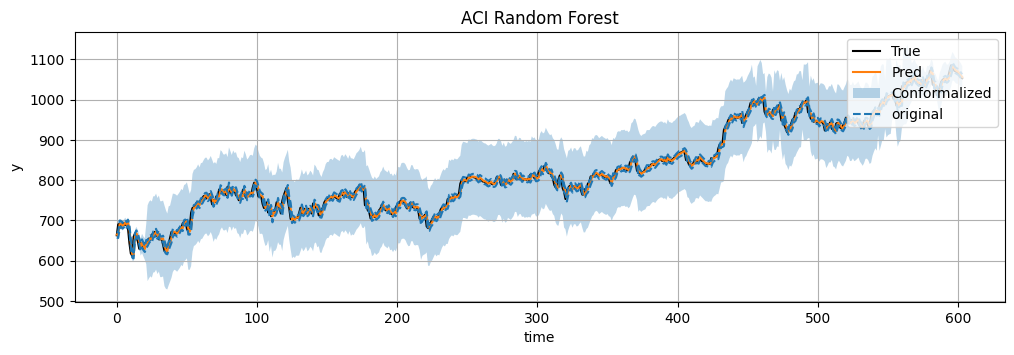

In [43]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QFR_predictions["middle"][0][df_test["t"],0],
               PI_low = QFR_predictions["lower"][0][df_test["t"],0], PI_hi = QFR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='ACI Random Forest')

## EnbPI

In [44]:
n_bs_samples = 20
enbpi = EnbPI(n_bs_samples=n_bs_samples)

X_bootstrap = np.concatenate([X_train, X_val], axis=0)
y_bootstrap = np.concatenate([y_train, y_val])

# train data is y_diff_lag and y_diff to predict eventually y
bs_indices, bs_train_data = enbpi.bootstrap(X_bootstrap, y_bootstrap)

In [45]:
model = QuantileForestRegressor(y_real=df["y"].to_numpy(), quantiles=[0.5], max_depth=2, differencing=False)

# we train on y diff lag and predict on X bootstrap and X test (both diff lag)
bs_train_preds, bs_test_preds = enbpi.train(model, n_bs_samples=n_bs_samples,
                                            bs_train_data=bs_train_data,
                                            X_train=np.array(X_bootstrap),
                                            X_test=X_test)

batch: 0 

3017it [00:26, 112.29it/s]


batch: 1 

3017it [00:26, 113.62it/s]


batch: 2 

3017it [00:27, 108.09it/s]


batch: 3 

3017it [00:26, 113.07it/s]


batch: 4 

3017it [00:26, 111.82it/s]


batch: 5 

3017it [00:28, 107.32it/s]


batch: 6 

3017it [00:26, 113.28it/s]


batch: 7 

3017it [00:26, 113.02it/s]


batch: 8 

3017it [00:24, 121.19it/s]


batch: 9 

3017it [00:24, 123.13it/s]


batch: 10 

2243it [00:19, 116.70it/s]


KeyboardInterrupt: 

In [ ]:
df_train_val = pd.concat([df_train, df_val], axis=0)

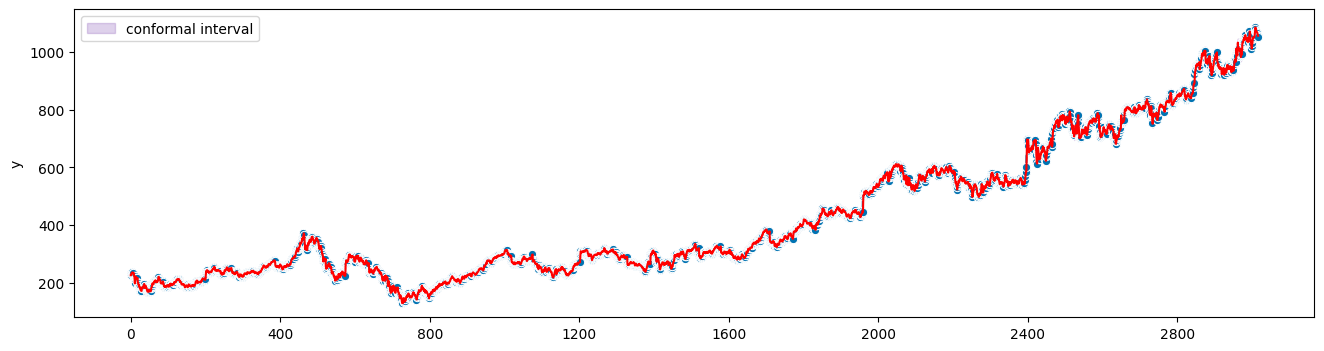

In [ ]:

# based on the diff lag predictions and actual
conformal_intervals = enbpi.create_conformal_interval_online(bs_indices=bs_indices,
                            bs_train_preds=bs_train_preds,
                            bs_test_preds=bs_test_preds,
                            y_train=df_train_val["y"].to_numpy(),
                            y_test=df_test["y"].to_numpy())

preds = np.mean(np.concatenate([bs_train_preds, bs_test_preds], axis=1), axis=0)


enbpi.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], preds, df_test["t"].to_numpy().reshape(-1,1), 
                            conformal_intervals)

metric = Metrics(df_test["y"].to_numpy(), preds[df_test["t"].to_numpy()], conformal_intervals[:,0], conformal_intervals[:,1],)
df_forest.loc[2] = metric.computeAll(model_name="Forest EnbPI").values()

<Figure size 640x480 with 0 Axes>

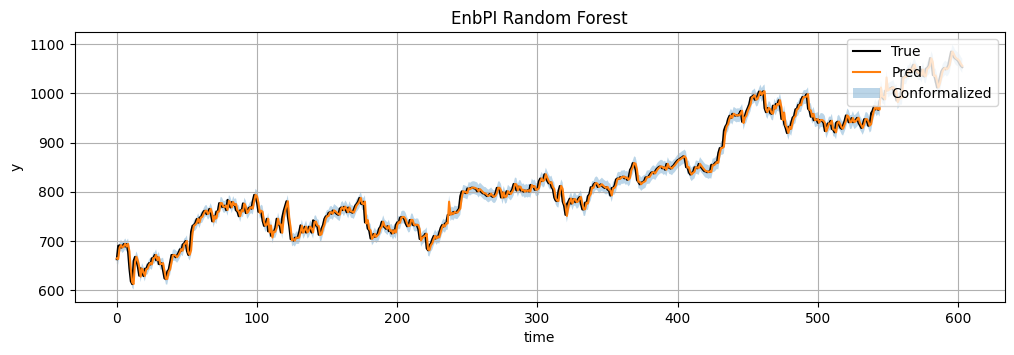

In [ ]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= preds[df_test["t"]],
               PI_low = None, PI_hi = None,
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='EnbPI Random Forest')

EnCQR

In [ ]:
df_train

,t,y,y_lag,y_diff,y_diff_lag
0,0,225.85,222.84,3.01,5.01
1,1,233.06,225.85,7.21,3.01
2,2,233.68,233.06,0.62,7.21
3,3,235.11,233.68,1.43,0.62
4,4,236.05,235.11,0.94,1.43
...,...,...,...,...,...
1805,1805,414.22,417.83,-3.61,1.65
1806,1806,413.07,414.22,-1.15,-3.61
1807,1807,411.18,413.07,-1.89,-1.15
1808,1808,407.56,411.18,-3.62,-1.89


In [ ]:
encqr = EnCQR(n_ensembles=3, alpha=0.1)
train_data, train_label, val_x, val_y, test_x, test_y = encqr.dataloader(df_train, df_val, df_test, differencing=True)


In [ ]:
model = QuantileForestRegressor(y_real=df["y"].to_numpy(), quantiles=[0.05, 0.5, 0.95], max_depth=2, differencing=False)

epsilon_low, epsilon_hi = encqr.train(df_train, train_label=train_label, model=model,
                                        train_data=train_data)


Training model for Sb: 0 

804it [00:05, 148.88it/s]
804it [00:05, 146.37it/s]


Training model for Sb: 1 

804it [00:05, 150.37it/s]
804it [00:05, 149.11it/s]


Training model for Sb: 2 

804it [00:05, 149.86it/s]
804it [00:05, 146.74it/s]


In [ ]:
test_y.shape

(604,)

In [ ]:
test_x.shape

(604, 1)

In [ ]:
test_start = len(df_train) + len(df_val)
test_start

2413

In [ ]:
test_label = df_test["y"].to_numpy()

In [ ]:
PI, conf_PI = encqr.construct_PI(epsilon_low=epsilon_low, epsilon_hi=epsilon_hi
                   , test_x = test_x,
                   test_y = test_y, test_label=test_label, test_start=test_start)

Creating test predictions for Sb 0


604it [00:03, 154.93it/s]


Creating test predictions for Sb 1


604it [00:03, 155.93it/s]


Creating test predictions for Sb 2


604it [00:03, 152.71it/s]


<Figure size 640x480 with 0 Axes>

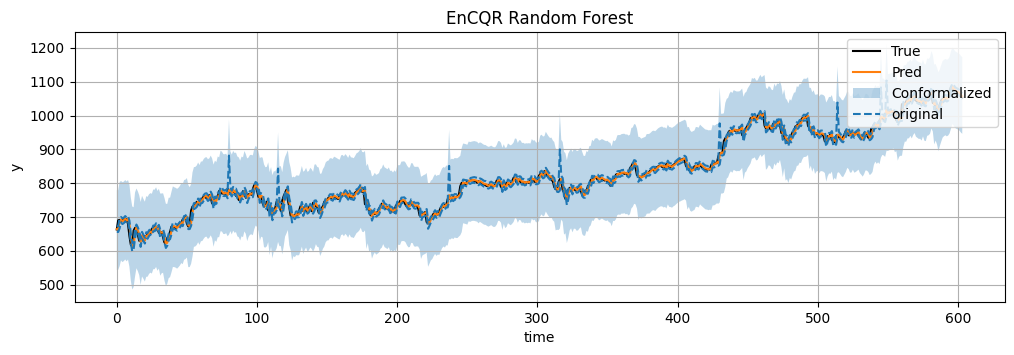

In [ ]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= PI[:, :, 1].flatten(),
               PI_low = PI[:, :, 0].flatten(), PI_hi = PI[:, :, 2].flatten(),
               conf_PI_low=conf_PI[:, :, 0].flatten(), conf_PI_hi=conf_PI[:, :, 2].flatten(),
               x_label="time", y_label="y", title='EnCQR Random Forest')

<Figure size 640x480 with 0 Axes>

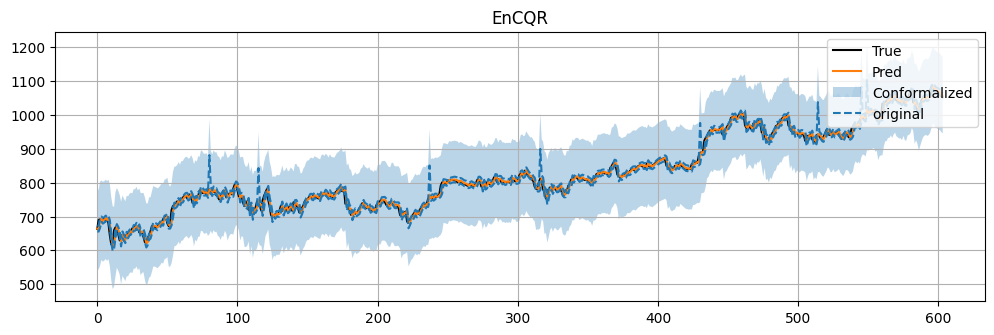

In [ ]:
# Plot original and conformalized PI
encqr.plot_PIs(df_test["y"].to_numpy(), PI[:,:,1],
               PI[:,:,0], PI[:,:,2],
               conf_PI[:,:,0], conf_PI[:,:,2], title='EnCQR')

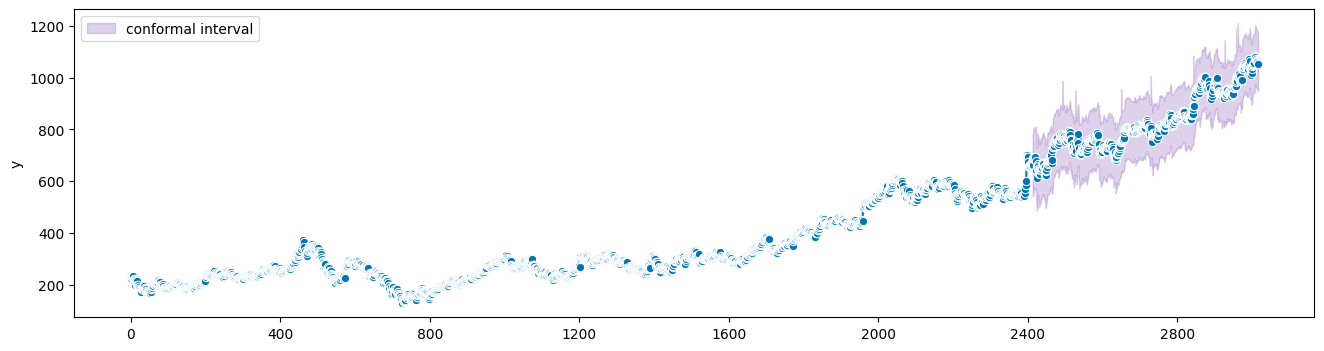

In [ ]:
encqr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], PI, df_test["t"].to_numpy().reshape(-1,1), conf_PI[:,0][:,[0,2]].reshape(-1,2))

preds =  conf_PI[:, :, 1]


metric = Metrics(df_test["y"].to_numpy(), preds, conf_PI[:,:, 0].flatten(), conf_PI[:,:,2].flatten(),)
df_forest.loc[3] = metric.computeAll(model_name="Forest EnCQR").values()

In [ ]:
df_forest

,model_name,RMSE,PICP,PIAW,PINAW,CWC
0,Forest CQR,9.811700,0.841060,25.930004,0.054864,0.851594
1,Forest ACI,9.811700,0.990066,174.751831,0.369751,0.494109
2,Forest EnbPI,10.037375,0.837748,26.225757,0.055490,0.840846
3,Forest EnCQR,9.974735,1.000000,236.002722,0.499350,0.370891


## Neural Regression with QRNN

Define metrics

In [ ]:
df_NN = pd.DataFrame({"model_name" : [],
                      "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [ ]:
predictions = []

In [ ]:
quantiles

{'lower': 0.05, 'middle': 0.5, 'upper': 0.95}

Quantile estimation

In [ ]:
layers = 4
neurons = 256
activation = "relu"
model = (layers, neurons, activation)
qrnn = QuantileNeuralRegressor(quantiles=list(quantiles.values()), n_inputs=1, model_params=model)

In [ ]:
logs = qrnn.fit(df_train["y_lag"].to_numpy().reshape(-1,1), df_train["y"].to_numpy(), n_epochs=15)

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        77.251        
      2   0.0005        13.445        
      3   0.0005         7.565        
      4   0.0005         3.600        
      5   0.0005         1.538        
      6   0.0005         1.265        
      7   0.0005         1.070        
      8   0.0005         1.100        
      9   0.0005         1.059        
     10   0.0005         1.044        
     11   0.0005         1.024        
     12   0.0005         1.034        
     13   0.0005         1.077        
     14   0.0005         1.070        
     15   0.0005         1.092

In [ ]:

y_pred = qrnn.predict(df["y_lag"].values.reshape(-1,1))

NN_predictions = {}
NN_predictions["lower"] = y_pred[:,0].reshape(1, -1, 1)
NN_predictions["middle"] = y_pred[:,1].reshape(1, -1, 1)
NN_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)


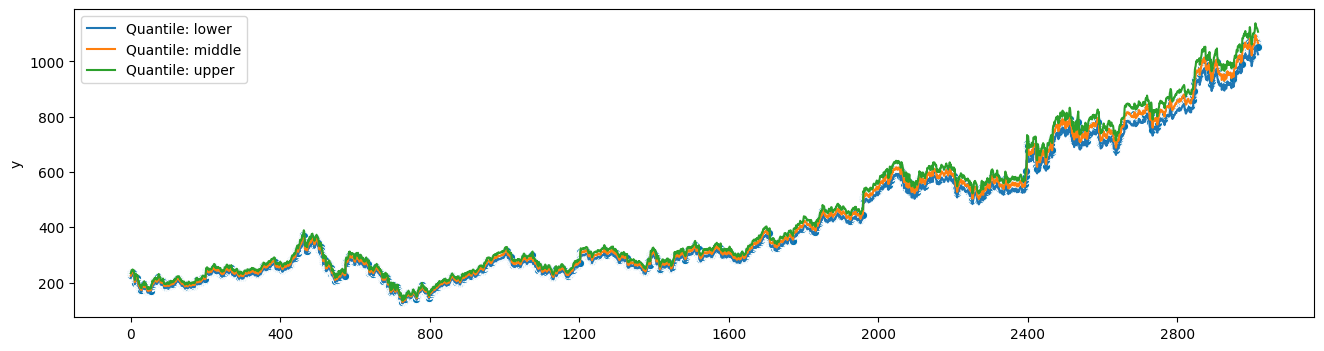

In [ ]:
qrnn.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], NN_predictions)

CQR

100%|██████████| 604/604 [00:01<00:00, 569.91it/s]


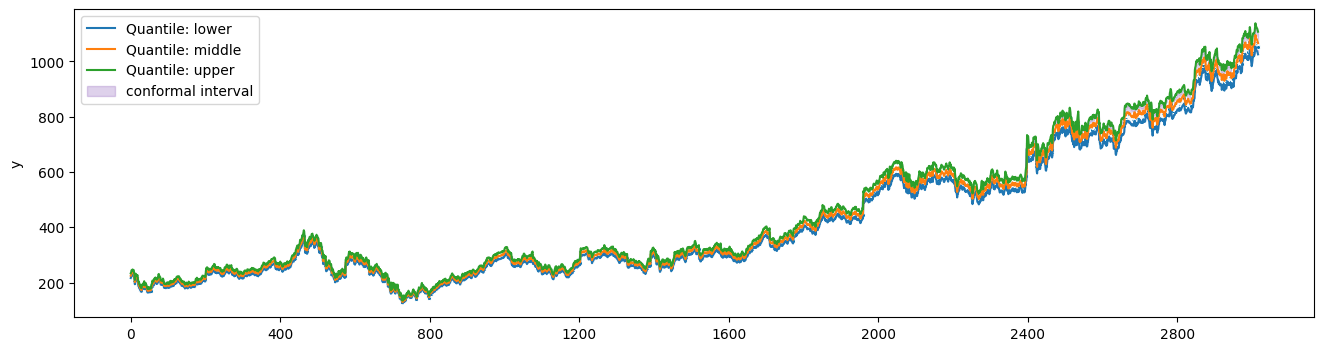

In [ ]:
qcr = CQR()
conformal_intervals = qcr.create_conformal_interval(NN_predictions, df_test["y"].to_numpy(), 
                                                    df_val["y"].to_numpy(), T,
                                                    tvt_split=tvt_split)
qcr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], NN_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((NN_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), NN_predictions["middle"][0][df_test["t"].to_numpy(), 0], conformal_intervals[:,0], conformal_intervals[:,1],)
df_NN.loc[0] = metric.computeAll(model_name="NN CQR").values()

<Figure size 640x480 with 0 Axes>

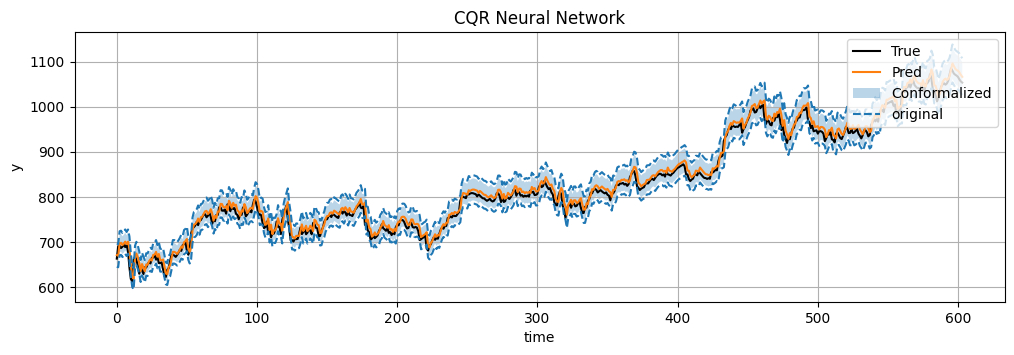

In [ ]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= NN_predictions["middle"][0][df_test["t"],0],
               PI_low = NN_predictions["lower"][0][df_test["t"],0], PI_hi = NN_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='CQR Neural Network')

ACI

100%|██████████| 604/604 [00:02<00:00, 223.91it/s]


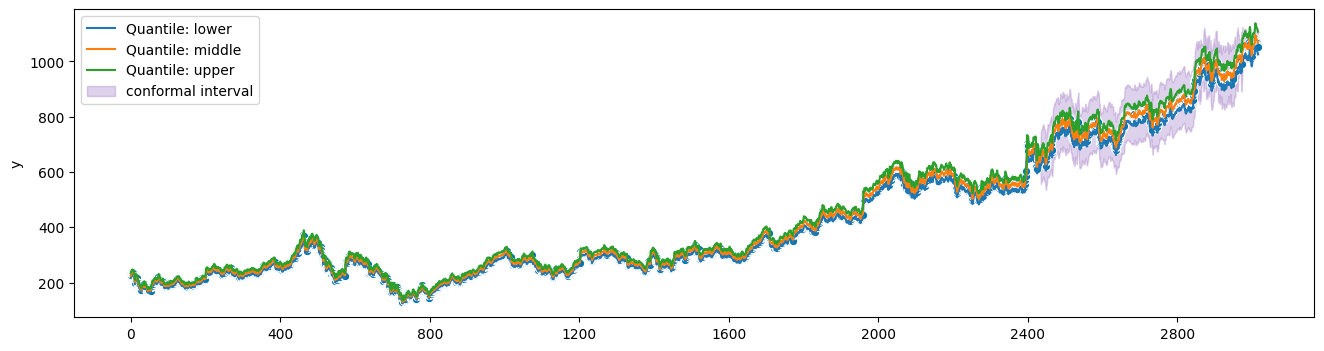

In [ ]:
aci = ACI()
conformal_intervals = aci.create_conformal_interval(NN_predictions, df_test["y"].to_numpy(), 
                                                    df_val["y"].to_numpy(), T,
                                                    tvt_split=tvt_split)
aci.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], NN_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((NN_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), NN_predictions["middle"][0][df_test["t"].to_numpy(), 0], conformal_intervals[:,0], conformal_intervals[:,1],)
df_NN.loc[1] = metric.computeAll(model_name="NN ACI").values()

<Figure size 640x480 with 0 Axes>

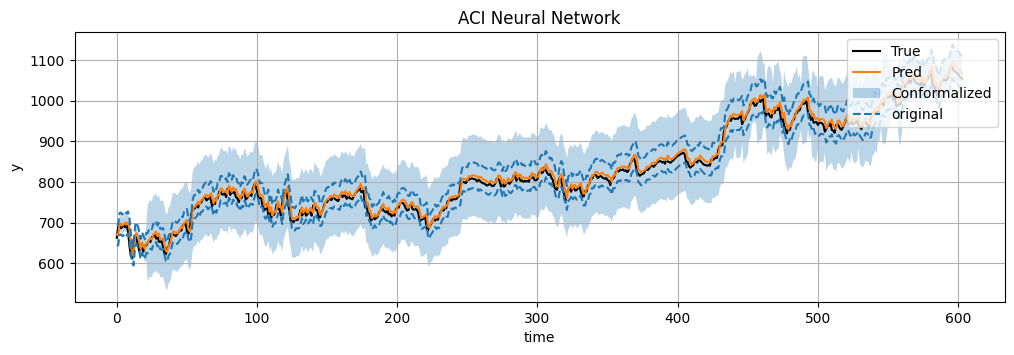

In [ ]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= NN_predictions["middle"][0][df_test["t"],0],
               PI_low = NN_predictions["lower"][0][df_test["t"],0], PI_hi = NN_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='ACI Neural Network')

EnbPI

In [ ]:
layers = 4
neurons = 256
activation = "relu"
model = (layers, neurons, activation)
qrnn = QuantileNeuralRegressor(quantiles=[0.5], n_inputs=1, model_params=model)

In [ ]:
n_bs_samples = 20
enbpi = EnbPI(n_bs_samples=n_bs_samples)

X_bootstrap = np.concatenate([df_train["y_lag"].to_numpy().reshape(-1,1), df_val["y_lag"].to_numpy().reshape(-1,1)], axis=0)
y_bootstrap = np.concatenate([df_train["y"].to_numpy(), df_val["y"].to_numpy()])

bs_indices, bs_train_data = enbpi.bootstrap(X_bootstrap, y_bootstrap)

In [ ]:
batch = pd.DataFrame({"y_lag" : bs_train_data[0][0][:,0], "y": bs_train_data[0][1].flatten()})

In [ ]:
from IPython.utils import io

In [ ]:
model = qrnn

# this is to hide the training logs
with io.capture_output() as captured:
    bs_train_preds, bs_test_preds = enbpi.train(model, n_bs_samples=n_bs_samples,
                                            bs_train_data=bs_train_data,
                                            X_train=np.array(X_bootstrap),
                                            X_test=df_test["y_lag"].to_numpy().reshape(-1,1))

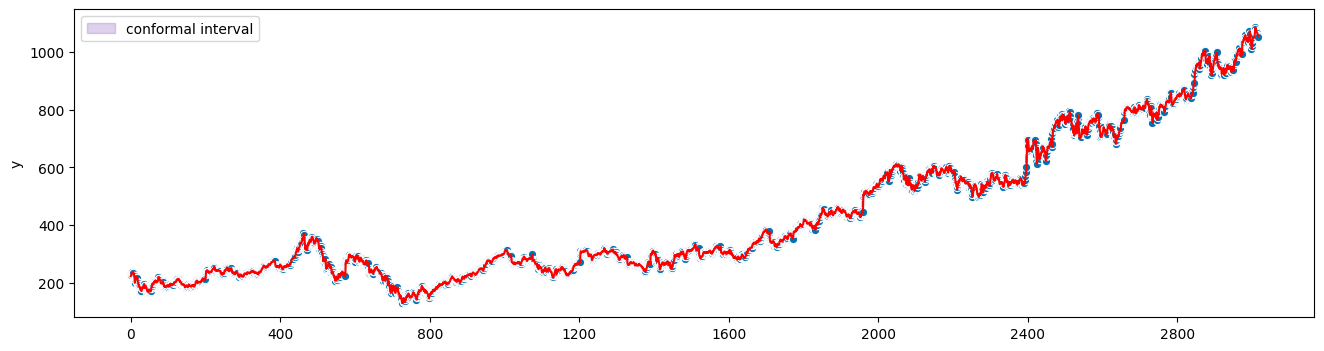

In [ ]:
conformal_intervals = enbpi.create_conformal_interval_online(bs_indices=bs_indices,
                            bs_train_preds=bs_train_preds,
                            bs_test_preds=bs_test_preds,
                            y_train=y_bootstrap,
                            y_test=df_test["y"].to_numpy())

preds = np.mean(np.concatenate([bs_train_preds, bs_test_preds], axis=1), axis=0)


enbpi.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], preds, df_test["t"].to_numpy().reshape(-1,1), 
                            conformal_intervals)

metric = Metrics(df_test["y"].to_numpy(), preds[df_test["t"].to_numpy()], conformal_intervals[:,0], conformal_intervals[:,1],)
df_NN.loc[2] = metric.computeAll(model_name="NN EnbPI").values()

<Figure size 640x480 with 0 Axes>

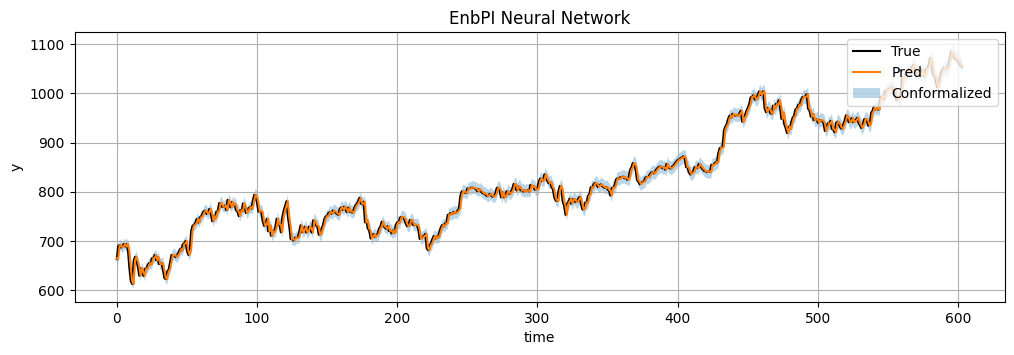

In [ ]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= preds[df_test["t"]],
               PI_low = None, PI_hi = None,
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='EnbPI Neural Network')

EnCQR

In [ ]:
encqr = EnCQR(n_ensembles=8, alpha=0.1)
train_data, train_label, val_x, val_y, test_x, test_y = encqr.dataloader(df_train, df_val, df_test)


In [ ]:
layers = 2
neurons = 128
activation = "relu"
model = (layers, neurons, activation)
qrnn = QuantileNeuralRegressor(quantiles=[0.05, 0.5, 0.95], n_inputs=1, model_params=model)

In [ ]:
model = qrnn
epsilon_low, epsilon_hi = encqr.train(df_train, train_label=train_label, model=model,
                                        train_data=train_data)


Output()

Training model for Sb: 0 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        104.876       
      2   0.0005        97.533        
      3   0.0005        91.097        
      4   0.0005        84.635        
      5   0.0005        78.101        
      6   0.0005        72.169        
      7   0.0005        65.970        
      8   0.0005        59.695        
      9   0.0005        53.824        
     10   0.0005        47.160        
     11   0.0005        40.373        
     12   0.0005        33.585        
     13   0.0005        26.539        
     14   0.0005        19.052        
     15   0.0005        12.758

Training model for Sb: 1 

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        12.810        
      2   0.0005         8.666        
      3   0.0005         4.669        
      4   0.0005         3.657        
      5   0.0005         4.949        
      6   0.0005         4.666        
      7   0.0005         3.514        
      8   0.0005         2.283        
      9   0.0005         2.734        
     10   0.0005         2.906        
     11   0.0005         2.092        
     12   0.0005         1.455        
     13   0.0005         1.734        
     14   0.0005         1.567        
     15   0.0005         1.298

Output()

Training model for Sb: 2 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.337        
      2   0.0005         1.202        
      3   0.0005         1.280        
      4   0.0005         1.251        
      5   0.0005         1.240        
      6   0.0005         1.164        
      7   0.0005         1.136        
      8   0.0005         1.170        
      9   0.0005         1.196        
     10   0.0005         1.162        
     11   0.0005         1.192        
     12   0.0005         1.172        
     13   0.0005         1.189        
     14   0.0005         1.183        
     15   0.0005         1.192

Output()

Training model for Sb: 3 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.365        
      2   0.0005         1.192        
      3   0.0005         1.382        
      4   0.0005         1.088        
      5   0.0005         1.115        
      6   0.0005         0.983        
      7   0.0005         1.143        
      8   0.0005         0.940        
      9   0.0005         0.984        
     10   0.0005         0.905        
     11   0.0005         0.868        
     12   0.0005         0.920        
     13   0.0005         0.879        
     14   0.0005         0.724        
     15   0.0005         0.868

Output()

Training model for Sb: 4 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.635        
      2   0.0005         1.366        
      3   0.0005         1.404        
      4   0.0005         1.165        
      5   0.0005         1.343        
      6   0.0005         1.123        
      7   0.0005         1.189        
      8   0.0005         1.028        
      9   0.0005         1.064        
     10   0.0005         0.998        
     11   0.0005         1.082        
     12   0.0005         0.967        
     13   0.0005         0.986        
     14   0.0005         0.992        
     15   0.0005         0.965

Output()

Training model for Sb: 5 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.596        
      2   0.0005         1.396        
      3   0.0005         1.235        
      4   0.0005         1.297        
      5   0.0005         1.210        
      6   0.0005         1.365        
      7   0.0005         1.192        
      8   0.0005         1.188        
      9   0.0005         1.014        
     10   0.0005         1.084        
     11   0.0005         1.002        
     12   0.0005         1.008        
     13   0.0005         0.942        
     14   0.0005         0.932        
     15   0.0005         0.948

Output()

Training model for Sb: 6 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         2.823        
      2   0.0005         2.015        
      3   0.0005         2.597        
      4   0.0005         1.607        
      5   0.0005         2.275        
      6   0.0005         1.641        
      7   0.0005         1.742        
      8   0.0005         1.399        
      9   0.0005         1.686        
     10   0.0005         1.626        
     11   0.0005         1.373        
     12   0.0005         1.551        
     13   0.0005         1.413        
     14   0.0005         1.552        
     15   0.0005         1.371

Output()

Training model for Sb: 7 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         3.405        
      2   0.0005         2.251        
      3   0.0005         3.119        
      4   0.0005         2.327        
      5   0.0005         2.683        
      6   0.0005         2.204        
      7   0.0005         2.203        
      8   0.0005         1.974        
      9   0.0005         1.783        
     10   0.0005         2.006        
     11   0.0005         1.684        
     12   0.0005         1.862        
     13   0.0005         1.704        
     14   0.0005         1.709        
     15   0.0005         1.678

In [ ]:
test_label = df_test["y"].to_numpy()

In [ ]:
PI, conf_PI = encqr.construct_PI(epsilon_low=epsilon_low, epsilon_hi=epsilon_hi
                   , test_x = test_x,
                   test_y = test_y, test_label=test_label)

Creating test predictions for Sb 0
Creating test predictions for Sb 1
Creating test predictions for Sb 2
Creating test predictions for Sb 3
Creating test predictions for Sb 4
Creating test predictions for Sb 5
Creating test predictions for Sb 6
Creating test predictions for Sb 7


In [ ]:
conf_PI.shape

(604, 1, 3)

In [ ]:
# # Plot original and conformalized PI
# encqr.plot_PIs(test_y, PI[:,:,1],
#                PI[:,:,0], PI[:,:,2],
#                conf_PI[:,:,0], conf_PI[:,:,2], title='EnCQR')

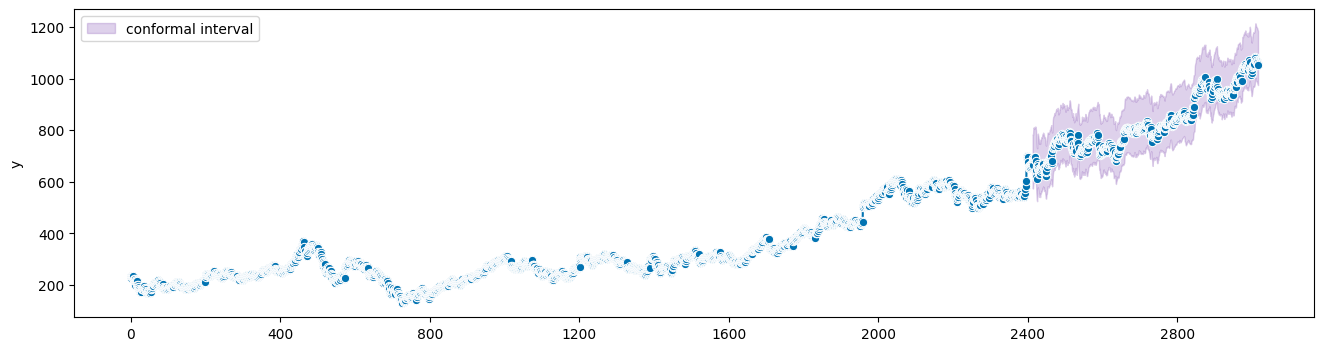

In [ ]:
encqr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], PI, df_test["t"].to_numpy().reshape(-1,1), conf_PI[:,0][:,[0,2]].reshape(-1,2))

preds =  conf_PI[:, :, 1]


metric = Metrics(df_test["y"].to_numpy(), preds, conf_PI[:,:, 0].flatten(), conf_PI[:,:,2].flatten(),)
df_NN.loc[3] = metric.computeAll(model_name="NN EnCQR").values()

<Figure size 640x480 with 0 Axes>

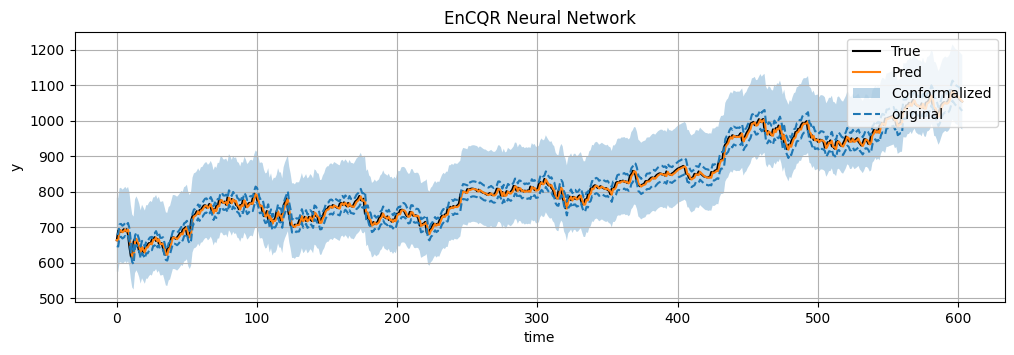

In [ ]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= PI[:, :, 1].flatten(),
               PI_low = PI[:, :, 0].flatten(), PI_hi = PI[:, :, 2].flatten(),
               conf_PI_low=conf_PI[:, :, 0].flatten(), conf_PI_hi=conf_PI[:, :, 2].flatten(),
               x_label="time", y_label="y", title='EnCQR Neural Network')

In [ ]:
df_NN

,model_name,RMSE,PICP,PIAW,PINAW,CWC
0,NN CQR,12.389177,0.935430,49.655319,0.105064,0.861860
1,NN ACI,12.389177,0.991722,182.642624,0.386447,0.476696
2,NN EnbPI,9.849789,0.844371,26.086237,0.055195,0.861040
3,NN EnCQR,10.011230,1.000000,212.837796,0.450336,0.407201


# Comparison

## Tables

In [ ]:
df_arima.to_csv(f"{dataset}_arima_100.csv")
df_arima

,model_name,RMSE,PICP,PIAW,PINAW,CWC
0,ARIMA,9.864323,0.786424,21.60564,0.045715,0.648056


In [ ]:
df_linear.to_csv(f"{dataset}_linear_100.csv")

In [ ]:
df_forest.to_csv(f"{dataset}_forest_100.csv")

In [ ]:
df_NN.to_csv(f"{dataset}_NN_100.csv")

GRID SEARCH

In [ ]:
# scores_lin, gamma_lin = optimize_conformal(model_predictions=QLR_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)

In [ ]:
# scores_rf, gamma_rf = optimize_conformal(model_predictions=QFR_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)

In [ ]:
# scores_nn, gamma_nn = optimize_conformal(model_predictions=NN_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)